## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 06:45:41,951] A new study created in memory with name: no-name-56bdd3e7-c045-410f-acf6-64d1a825bfb5


7/7 [==============================] - 1s 12ms/step


[I 2023-06-14 06:46:01,539] Trial 0 finished with value: 107.86191885193132 and parameters: {'window_size': 18, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.1661354414442509, 'attention_dim': 27}. Best is trial 0 with value: 107.86191885193132.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 06:46:15,565] Trial 1 finished with value: 96.41060755403777 and parameters: {'window_size': 45, 'tcn_filters': 60, 'tcn_kernel_size': 2, 'dropout_rate': 0.19530495486155078, 'attention_dim': 28}. Best is trial 1 with value: 96.41060755403777.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 06:46:37,449] Trial 2 finished with value: 282.69973768278203 and parameters: {'window_size': 60, 'tcn_filters': 58, 'tcn_kernel_size': 4, 'dropout_rate': 0.2536163562889585, 'attention_dim': 31}. Best is trial 1 with value: 96.41060755403777.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 06:46:47,998] Trial 3 finished with value: 246.2857076700038 and parameters: {'window_size': 46, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.488065724817371, 'attention_dim': 12}. Best is trial 1 with value: 96.41060755403777.


6/6 [==============================] - 0s 9ms/step


[I 2023-06-14 06:47:05,285] Trial 4 finished with value: 108.95619125907112 and parameters: {'window_size': 52, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.31208049868222343, 'attention_dim': 13}. Best is trial 1 with value: 96.41060755403777.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 06:47:16,986] Trial 5 finished with value: 84.67810084292638 and parameters: {'window_size': 40, 'tcn_filters': 50, 'tcn_kernel_size': 3, 'dropout_rate': 0.1597590185750021, 'attention_dim': 28}. Best is trial 5 with value: 84.67810084292638.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 06:47:21,556] Trial 6 finished with value: 76.46355570985759 and parameters: {'window_size': 28, 'tcn_filters': 32, 'tcn_kernel_size': 5, 'dropout_rate': 0.22279026689443562, 'attention_dim': 22}. Best is trial 6 with value: 76.46355570985759.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:47:28,699] Trial 7 finished with value: 85.10504696499099 and parameters: {'window_size': 31, 'tcn_filters': 60, 'tcn_kernel_size': 4, 'dropout_rate': 0.4893252147104631, 'attention_dim': 22}. Best is trial 6 with value: 76.46355570985759.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:47:32,900] Trial 8 finished with value: 50.52211624736872 and parameters: {'window_size': 14, 'tcn_filters': 85, 'tcn_kernel_size': 3, 'dropout_rate': 0.46779662336286587, 'attention_dim': 19}. Best is trial 8 with value: 50.52211624736872.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 06:47:52,205] Trial 9 finished with value: 140.2662421561086 and parameters: {'window_size': 87, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.185855265674822, 'attention_dim': 9}. Best is trial 8 with value: 50.52211624736872.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 06:47:59,369] Trial 10 finished with value: 46.95179697150985 and parameters: {'window_size': 10, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.39385695745484794, 'attention_dim': 17}. Best is trial 10 with value: 46.95179697150985.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:48:06,467] Trial 11 finished with value: 42.43407546344812 and parameters: {'window_size': 11, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.40811950852880763, 'attention_dim': 17}. Best is trial 11 with value: 42.43407546344812.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:48:14,229] Trial 12 finished with value: 42.296939439743944 and parameters: {'window_size': 12, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.3905853756534794, 'attention_dim': 17}. Best is trial 12 with value: 42.296939439743944.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 06:48:26,625] Trial 13 finished with value: 243.40062575917977 and parameters: {'window_size': 67, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.3840163102055123, 'attention_dim': 15}. Best is trial 12 with value: 42.296939439743944.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:48:33,735] Trial 14 finished with value: 76.22690469402207 and parameters: {'window_size': 27, 'tcn_filters': 78, 'tcn_kernel_size': 4, 'dropout_rate': 0.37883324470890833, 'attention_dim': 20}. Best is trial 12 with value: 42.296939439743944.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 06:48:45,702] Trial 15 finished with value: 339.8470102797733 and parameters: {'window_size': 85, 'tcn_filters': 75, 'tcn_kernel_size': 3, 'dropout_rate': 0.3198778150882386, 'attention_dim': 9}. Best is trial 12 with value: 42.296939439743944.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 06:49:03,231] Trial 16 finished with value: 281.1357880817833 and parameters: {'window_size': 73, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.43265505175326485, 'attention_dim': 24}. Best is trial 12 with value: 42.296939439743944.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 06:49:25,746] Trial 17 finished with value: 236.80234459214475 and parameters: {'window_size': 98, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.3498739970053751, 'attention_dim': 17}. Best is trial 12 with value: 42.296939439743944.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:49:32,404] Trial 18 finished with value: 92.91690107181181 and parameters: {'window_size': 23, 'tcn_filters': 115, 'tcn_kernel_size': 3, 'dropout_rate': 0.10026640093811762, 'attention_dim': 13}. Best is trial 12 with value: 42.296939439743944.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 06:49:40,804] Trial 19 finished with value: 92.66638251713195 and parameters: {'window_size': 34, 'tcn_filters': 69, 'tcn_kernel_size': 4, 'dropout_rate': 0.43454128978434825, 'attention_dim': 17}. Best is trial 12 with value: 42.296939439743944.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:49:50,096] Trial 20 finished with value: 106.05164332329592 and parameters: {'window_size': 20, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.2770455888344694, 'attention_dim': 24}. Best is trial 12 with value: 42.296939439743944.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:49:56,578] Trial 21 finished with value: 37.71428442535037 and parameters: {'window_size': 10, 'tcn_filters': 87, 'tcn_kernel_size': 3, 'dropout_rate': 0.4075764038726732, 'attention_dim': 16}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:50:01,144] Trial 22 finished with value: 53.507690463241026 and parameters: {'window_size': 14, 'tcn_filters': 83, 'tcn_kernel_size': 3, 'dropout_rate': 0.34319068850416357, 'attention_dim': 15}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:50:09,497] Trial 23 finished with value: 68.40748210405599 and parameters: {'window_size': 19, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.42557177308803085, 'attention_dim': 19}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 06:50:13,087] Trial 24 finished with value: 51.525723478956166 and parameters: {'window_size': 10, 'tcn_filters': 72, 'tcn_kernel_size': 3, 'dropout_rate': 0.4079207814091728, 'attention_dim': 11}. Best is trial 21 with value: 37.71428442535037.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 06:50:25,329] Trial 25 finished with value: 101.16386623673846 and parameters: {'window_size': 36, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.4556076991206851, 'attention_dim': 15}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:50:32,667] Trial 26 finished with value: 79.29749561396997 and parameters: {'window_size': 25, 'tcn_filters': 87, 'tcn_kernel_size': 3, 'dropout_rate': 0.36560120561759246, 'attention_dim': 20}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:50:40,566] Trial 27 finished with value: 46.90862026424415 and parameters: {'window_size': 10, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.4058283400712366, 'attention_dim': 16}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:50:46,369] Trial 28 finished with value: 53.334714232650825 and parameters: {'window_size': 17, 'tcn_filters': 81, 'tcn_kernel_size': 3, 'dropout_rate': 0.33833182002017825, 'attention_dim': 18}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:50:54,422] Trial 29 finished with value: 87.8212857310978 and parameters: {'window_size': 18, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.3652285099392125, 'attention_dim': 22}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:50:59,524] Trial 30 finished with value: 73.62393264243316 and parameters: {'window_size': 24, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.4554956289147448, 'attention_dim': 14}. Best is trial 21 with value: 37.71428442535037.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:51:07,480] Trial 31 finished with value: 37.6427310088589 and parameters: {'window_size': 11, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.40691387783358784, 'attention_dim': 16}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:51:14,961] Trial 32 finished with value: 52.73972849614269 and parameters: {'window_size': 15, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.4028051106462007, 'attention_dim': 18}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:51:22,708] Trial 33 finished with value: 48.8767864677337 and parameters: {'window_size': 10, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.4209290714975174, 'attention_dim': 12}. Best is trial 31 with value: 37.6427310088589.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 06:51:45,391] Trial 34 finished with value: 91.30409337182273 and parameters: {'window_size': 42, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.38156706687713277, 'attention_dim': 32}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:51:53,242] Trial 35 finished with value: 76.29261132607782 and parameters: {'window_size': 22, 'tcn_filters': 96, 'tcn_kernel_size': 3, 'dropout_rate': 0.4319495313776099, 'attention_dim': 11}. Best is trial 31 with value: 37.6427310088589.


6/6 [==============================] - 1s 7ms/step


[I 2023-06-14 06:52:06,371] Trial 36 finished with value: 98.07758070705974 and parameters: {'window_size': 51, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.2990488398927421, 'attention_dim': 16}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:52:13,733] Trial 37 finished with value: 66.20966840880259 and parameters: {'window_size': 31, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.36222060134501055, 'attention_dim': 20}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 06:52:21,712] Trial 38 finished with value: 53.18726531577897 and parameters: {'window_size': 16, 'tcn_filters': 65, 'tcn_kernel_size': 2, 'dropout_rate': 0.49708653489838694, 'attention_dim': 14}. Best is trial 31 with value: 37.6427310088589.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 06:52:31,419] Trial 39 finished with value: 380.19758818845617 and parameters: {'window_size': 59, 'tcn_filters': 38, 'tcn_kernel_size': 4, 'dropout_rate': 0.4549799325415066, 'attention_dim': 25}. Best is trial 31 with value: 37.6427310088589.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 06:52:44,268] Trial 40 finished with value: 207.9906590982046 and parameters: {'window_size': 37, 'tcn_filters': 56, 'tcn_kernel_size': 3, 'dropout_rate': 0.38860416349889665, 'attention_dim': 22}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:52:51,917] Trial 41 finished with value: 55.095133664226246 and parameters: {'window_size': 10, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.40656155535681476, 'attention_dim': 16}. Best is trial 31 with value: 37.6427310088589.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:52:59,123] Trial 42 finished with value: 34.725742340894215 and parameters: {'window_size': 13, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.4073574481399635, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:53:06,593] Trial 43 finished with value: 71.8813384941593 and parameters: {'window_size': 29, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.47826988133582893, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:53:11,659] Trial 44 finished with value: 64.96290893492068 and parameters: {'window_size': 14, 'tcn_filters': 83, 'tcn_kernel_size': 2, 'dropout_rate': 0.41897220232574317, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:53:20,920] Trial 45 finished with value: 50.470756333417874 and parameters: {'window_size': 21, 'tcn_filters': 76, 'tcn_kernel_size': 3, 'dropout_rate': 0.3782010826280461, 'attention_dim': 14}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:53:28,289] Trial 46 finished with value: 44.158321667728906 and parameters: {'window_size': 14, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.4458896002011809, 'attention_dim': 21}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:53:35,721] Trial 47 finished with value: 72.80574491232768 and parameters: {'window_size': 25, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.3941485590171271, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:53:43,011] Trial 48 finished with value: 59.27345896421273 and parameters: {'window_size': 19, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.47449560765080223, 'attention_dim': 13}. Best is trial 42 with value: 34.725742340894215.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 06:53:51,563] Trial 49 finished with value: 98.06918605162905 and parameters: {'window_size': 32, 'tcn_filters': 74, 'tcn_kernel_size': 3, 'dropout_rate': 0.44432482849432464, 'attention_dim': 21}. Best is trial 42 with value: 34.725742340894215.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 06:54:00,880] Trial 50 finished with value: 156.3799519181291 and parameters: {'window_size': 49, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.4165791735471336, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:54:06,179] Trial 51 finished with value: 50.56261846949113 and parameters: {'window_size': 14, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.4449804448146431, 'attention_dim': 21}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:54:13,664] Trial 52 finished with value: 64.38964417734226 and parameters: {'window_size': 13, 'tcn_filters': 90, 'tcn_kernel_size': 5, 'dropout_rate': 0.3963476557490684, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:54:22,337] Trial 53 finished with value: 80.6879576107853 and parameters: {'window_size': 18, 'tcn_filters': 79, 'tcn_kernel_size': 5, 'dropout_rate': 0.47225175311083545, 'attention_dim': 23}. Best is trial 42 with value: 34.725742340894215.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:54:45,948] Trial 54 finished with value: 320.5813314463095 and parameters: {'window_size': 71, 'tcn_filters': 85, 'tcn_kernel_size': 5, 'dropout_rate': 0.4195087573851526, 'attention_dim': 27}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:54:50,822] Trial 55 finished with value: 57.105373497182086 and parameters: {'window_size': 13, 'tcn_filters': 100, 'tcn_kernel_size': 3, 'dropout_rate': 0.43892808868621536, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:54:57,727] Trial 56 finished with value: 84.22888999295847 and parameters: {'window_size': 21, 'tcn_filters': 94, 'tcn_kernel_size': 2, 'dropout_rate': 0.4616867309546835, 'attention_dim': 15}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 06:55:06,046] Trial 57 finished with value: 107.88061059589488 and parameters: {'window_size': 27, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.48822755827420355, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:55:13,982] Trial 58 finished with value: 98.43955721731041 and parameters: {'window_size': 12, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.4306896776986572, 'attention_dim': 21}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 06:55:21,216] Trial 59 finished with value: 70.07823587355901 and parameters: {'window_size': 17, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.3787832305521116, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:55:28,846] Trial 60 finished with value: 63.34362122093914 and parameters: {'window_size': 23, 'tcn_filters': 99, 'tcn_kernel_size': 3, 'dropout_rate': 0.4099124926419258, 'attention_dim': 8}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:55:37,391] Trial 61 finished with value: 41.82841956753692 and parameters: {'window_size': 11, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.40020561797066984, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:55:41,930] Trial 62 finished with value: 37.57605673170745 and parameters: {'window_size': 10, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.39143110541458637, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:55:50,559] Trial 63 finished with value: 86.24634149105977 and parameters: {'window_size': 10, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.39636563697593336, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:55:55,694] Trial 64 finished with value: 57.69713948023741 and parameters: {'window_size': 17, 'tcn_filters': 96, 'tcn_kernel_size': 2, 'dropout_rate': 0.3526559735275665, 'attention_dim': 15}. Best is trial 42 with value: 34.725742340894215.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 06:56:11,631] Trial 65 finished with value: 170.12797586683743 and parameters: {'window_size': 81, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.3776740889211378, 'attention_dim': 14}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:56:18,613] Trial 66 finished with value: 40.10749535837204 and parameters: {'window_size': 12, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.40817572140296965, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


4/4 [==============================] - 0s 19ms/step


[I 2023-06-14 06:56:33,760] Trial 67 finished with value: 181.87347690977433 and parameters: {'window_size': 100, 'tcn_filters': 104, 'tcn_kernel_size': 2, 'dropout_rate': 0.36719920629019315, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:56:39,939] Trial 68 finished with value: 47.69008414187125 and parameters: {'window_size': 16, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.390010325418573, 'attention_dim': 12}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 1s 6ms/step


[I 2023-06-14 06:56:48,256] Trial 69 finished with value: 38.82968171161172 and parameters: {'window_size': 13, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.42691400485759423, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:56:54,570] Trial 70 finished with value: 51.68607733509281 and parameters: {'window_size': 20, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.42045946072421747, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:56:59,440] Trial 71 finished with value: 42.82636548594437 and parameters: {'window_size': 12, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.40963045734504216, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:57:07,055] Trial 72 finished with value: 80.22977171583797 and parameters: {'window_size': 12, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.4308121760642918, 'attention_dim': 15}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:57:14,276] Trial 73 finished with value: 65.5789793482695 and parameters: {'window_size': 16, 'tcn_filters': 102, 'tcn_kernel_size': 2, 'dropout_rate': 0.39762672128774595, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:57:19,396] Trial 74 finished with value: 39.91244104742094 and parameters: {'window_size': 10, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.4120105728406254, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 06:57:26,655] Trial 75 finished with value: 62.63318867727192 and parameters: {'window_size': 19, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.4277996443716676, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:57:34,632] Trial 76 finished with value: 51.7365934868642 and parameters: {'window_size': 10, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.40611055959137504, 'attention_dim': 13}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:57:39,686] Trial 77 finished with value: 86.15060307729568 and parameters: {'window_size': 15, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.43911002296797025, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:57:50,816] Trial 78 finished with value: 51.692631128437895 and parameters: {'window_size': 23, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.41535716354500096, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 06:57:56,665] Trial 79 finished with value: 48.38990286157344 and parameters: {'window_size': 12, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.3835974217614629, 'attention_dim': 14}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:58:05,429] Trial 80 finished with value: 80.64676512609738 and parameters: {'window_size': 27, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.4035009422784475, 'attention_dim': 15}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:58:12,770] Trial 81 finished with value: 73.61251337268962 and parameters: {'window_size': 15, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.39014174549745995, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:58:18,510] Trial 82 finished with value: 44.4307202513713 and parameters: {'window_size': 10, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.3714350822527655, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:58:25,707] Trial 83 finished with value: 58.077533754753276 and parameters: {'window_size': 13, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.4241600659293737, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:58:32,602] Trial 84 finished with value: 41.489744040104206 and parameters: {'window_size': 18, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3595980280893498, 'attention_dim': 20}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 06:58:39,861] Trial 85 finished with value: 55.59506957563893 and parameters: {'window_size': 19, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3994987826728269, 'attention_dim': 20}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:58:45,772] Trial 86 finished with value: 37.19804611177401 and parameters: {'window_size': 17, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.3600598091361505, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:58:50,149] Trial 87 finished with value: 50.92724913050744 and parameters: {'window_size': 17, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.3587941818463132, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:58:58,057] Trial 88 finished with value: 58.77656053229012 and parameters: {'window_size': 21, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.34316467832484304, 'attention_dim': 20}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 06:59:20,677] Trial 89 finished with value: 58.27530025559061 and parameters: {'window_size': 25, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.37363905236325945, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:59:28,284] Trial 90 finished with value: 35.948879260893115 and parameters: {'window_size': 15, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.3274576356618159, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 06:59:34,692] Trial 91 finished with value: 70.88940822975921 and parameters: {'window_size': 15, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.38776900147851673, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:59:42,472] Trial 92 finished with value: 101.83738284675319 and parameters: {'window_size': 13, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.3322050834485158, 'attention_dim': 15}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 06:59:49,663] Trial 93 finished with value: 63.210638384356116 and parameters: {'window_size': 17, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.3538263089151125, 'attention_dim': 17}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 07:00:02,583] Trial 94 finished with value: 42.91240213384023 and parameters: {'window_size': 14, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.36049698027633437, 'attention_dim': 18}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 07:00:16,161] Trial 95 finished with value: 53.4487732699728 and parameters: {'window_size': 21, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.32928238674325017, 'attention_dim': 20}. Best is trial 42 with value: 34.725742340894215.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 07:00:25,499] Trial 96 finished with value: 139.9312737405121 and parameters: {'window_size': 44, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.37129649756733546, 'attention_dim': 30}. Best is trial 42 with value: 34.725742340894215.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 07:00:49,230] Trial 97 finished with value: 203.79941587379062 and parameters: {'window_size': 92, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.34721901636615665, 'attention_dim': 14}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 07:00:54,768] Trial 98 finished with value: 48.96093950845289 and parameters: {'window_size': 19, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.4147149705348073, 'attention_dim': 19}. Best is trial 42 with value: 34.725742340894215.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 07:01:02,019] Trial 99 finished with value: 46.73358146250661 and parameters: {'window_size': 12, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.38285101770022173, 'attention_dim': 16}. Best is trial 42 with value: 34.725742340894215.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 13, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.4073574481399635, 'attention_dim': 18}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.09139305425753927
RMSE on Test dataset:  5.892855194292001
MSLE on Test dataset:  0.012205911212668171


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 23ms/step


## Visualization

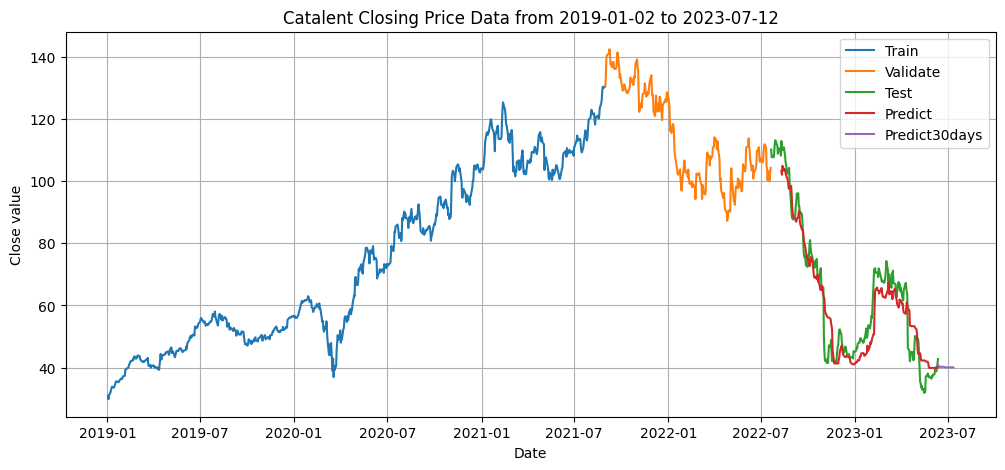

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_CTLT.png')
plt.show()